## Проект: анализ спроса билетов на авиасообщения по городам России.

### Напишите парсер для сбора с сайта данных о 11 крупнейших фестивалях 2018 года. Сохраните данные в датафрейм festivals и выведите на экран.
### Ссылка на сайт: https://code.s3.yandex.net/learning-materials/data-analyst/festival_news/index.html

In [1]:
# Импортируем необходимые для анализа библиотеки
import pandas as pd
import requests
import lxml
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,8) 
plt.style.use('ggplot') 
import seaborn as sns
import scipy as sp
import scipy.stats as stats

In [2]:

URL='https://code.s3.yandex.net/learning-materials/data-analyst/festival_news/index.html'
req = requests.get(URL)
soup = BeautifulSoup(req.text, 'lxml')

heading_table = []
for row in soup.find_all('th'):
    heading_table.append(row.text)

content = []
for row in soup.find_all('tr'):
    if not row.find_all('th'):
        content.append([element.text for element in row.find_all('td')])
        
festivals = pd.DataFrame(content, columns=heading_table)

print(festivals)

                                  Название фестиваля Место проведения  \
0               Музыкальный фестиваль «Усадьба Jazz»     Екатеринбург   
1   Фестиваль музыки и технологий Alfa Future People  Нижний Новгород   
2                        Фестиваль еды «О, да! Еда!»  Санкт-Петербург   
3                                          Доброфест        Ярославль   
4                                          Park Live           Москва   
5                                       Пикник Афиши           Москва   
6                                            VK FEST  Санкт-Петербург   
7                            Фестиваль «О, да! Еда!»          Иркутск   
8                            Фестиваль «О, да! Еда!»      Владивосток   
9                                            Видфест           Москва   
10                                  «Нашествие 2018»            Тверь   

   Дата проведения  
0       01.07.2018  
1       10.08.2018  
2       21.07.2018  
3       29.07.2018  
4       28.07.2018

### Шаг 1. Исследование данных и первичная предобработка

In [1]:
# Импортируем необходимые для анализа библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,8) 
plt.style.use('ggplot') 
import seaborn as sns
import scipy as sp
import scipy.stats as stats

In [2]:
# Создадим переменную с датасетом, посвященному количеству авиаперелетов в зависимости от модели самолета
models = pd.read_csv('https://code.s3.yandex.net/datasets/query_1.csv')
models

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


    В этой таблице содержится информация о количестве проданных билетов на каждой модели самолёта с вылетом в сентябре 2018 года.

In [3]:
# Создадим переменную с датасетом, посвященному среднему количеству авиасообщений по городам
city = pd.read_csv('https://code.s3.yandex.net/datasets/query_3.csv')
city

,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613
...,...,...
96,Чита,1.580645
97,Элиста,4.870968
98,Южно-Сахалинск,4.290323
99,Якутск,2.741935


    В данной таблице расчитано среднее количество прибывающих рейсов в день для каждого города за август 2018 года.

    Проведем первичное описание данных и оценим статистику мер центральных тенденций.

In [4]:
# Проверим количество уникальных значений: представлено 8 моделей
models.nunique()

model             8
flights_amount    8
dtype: int64

In [5]:
# Проверим типы переменных: приведение типов верное
models.dtypes

model             object
flights_amount     int64
dtype: object

In [6]:
# Проверим наличие пропущенных значений: их нет.
models.isna().sum()

model             0
flights_amount    0
dtype: int64

In [7]:
# Проверим наличие дубликатов: их нет
models.duplicated().sum()

0

In [8]:
# Проверим количество уникальных значений: представлены рейсы по направлению в 101 город = кол-ву строк - нет дубликатов
city.nunique()

city               101
average_flights     60
dtype: int64

In [9]:
# Проверим типы переменных: приведение типов верное
city.dtypes

city                object
average_flights    float64
dtype: object

In [10]:
# Проверим наличие пропущенных значений: их нет
city.isna().sum()

city               0
average_flights    0
dtype: int64

    В следующем шаге проведем небольшой разведовательный анализ количественных характеристик спроса на рейсы по направлениям и моделям самолетов.

### Шаг 2 Разведовательный анализ 

    Выберем топ-10 городов по количеству рейсов (посчитаем по средним значениям)

In [11]:
top_10_city = city.sort_values(by='average_flights', ascending=False).reset_index(drop=True).head(10)
top_10_city

,city,average_flights
0,Москва,129.774194
1,Санкт-Петербург,31.161290
2,Новосибирск,17.322581
3,Красноярск,11.580645
4,Екатеринбург,11.322581
5,Ростов-на-Дону,10.193548
6,Пермь,10.129032
7,Брянск,10.000000
8,Сочи,9.612903
9,Ульяновск,9.580645


In [12]:
#  Предварительно отсортируем значения количества перелетов по убыванию в таблице models
models = models.sort_values(by='flights_amount', ascending=False)
models

,model,flights_amount
6,Cessna 208 Caravan,4557
5,Bombardier CRJ-200,4446
7,Sukhoi SuperJet-100,4185
1,Airbus A321-200,960
2,Boeing 737-300,630
0,Airbus A319-100,607
3,Boeing 767-300,600
4,Boeing 777-300,300


In [13]:
# Предварительно отсортируем значения среднего количества перелетов в день за агвуст 2018 года по городам, округлим до 1 знака после точки.
city = city.sort_values(by='average_flights', ascending=False).round(1)
city

,city,average_flights
43,Москва,129.8
70,Санкт-Петербург,31.2
54,Новосибирск,17.3
33,Красноярск,11.6
20,Екатеринбург,11.3
...,...,...
22,Ижевск,1.0
65,Петропавловск-Камчатский,1.0
31,Комсомольск-на-Амуре,1.0
58,Нягань,1.0


    Построим график: город и среднее количество рейсов

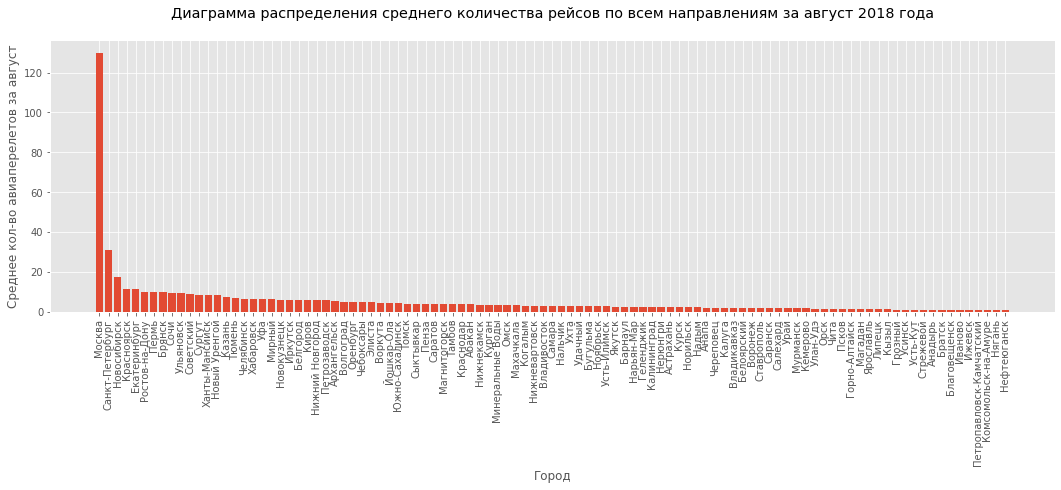

In [14]:
f, ax = plt.subplots(figsize=(18,5))
plot=plt.bar(city['city'], city['average_flights'])
x = plt.xticks(rotation='vertical')
plt.title('Диаграмма распределения среднего количества рейсов по всем направлениям за август 2018 года' + "\n")
plt.xlabel('Город')
plt.ylabel('Среднее кол-во авиаперелетов за август');

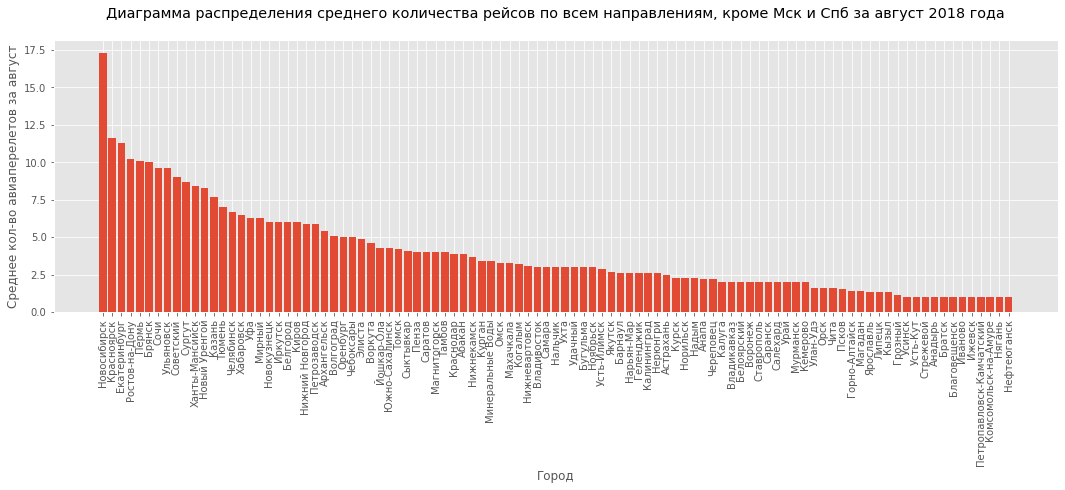

In [15]:
f, ax = plt.subplots(figsize=(18,5))
plot=plt.bar(city.query('(city != "Москва") & (city != "Санкт-Петербург")')['city'], city.query('(city != "Москва") & (city != "Санкт-Петербург")')['average_flights'])
x = plt.xticks(rotation='vertical')
plt.title('Диаграмма распределения среднего количества рейсов по всем направлениям, кроме Мск и Спб за август 2018 года' + "\n")
plt.xlabel('Город')
plt.ylabel('Среднее кол-во авиаперелетов за август');

    Предсказуемо, наибольшее среднее количество в день проданных билетов за август 2018 года мы наблюдаем для 5 городов-миллиоников: Москва, Санкт-Петербург, Новосибирск, Красноярск и Екатеринбург. Распределение значений очень напоминаем экспоненциальное. Рейсы на Москву, зачастую, являются состыковочными - так как авиасообщения в России зачастую центрированы на столичных аэропортах. Любопытно, однако, что мера центральной тенденции для авиаперелетов в августе по направлению Сочи весьма близка средним в день вылетам по таким направлениям как Брянск и Пермь, несмотря на то, что август - курортный сезон. Между тем, следует учитывать, что с 14 июня по 15 июля 2018 года в России проходил Чемпионат Мира по фотболу и как раз в июле 2018 года в Сочи состоялся матч за выход в полуфинал между Россией и Хорватией - в этот период многие болельщики покупали билет в Сочи, несмотря на непредсказуемый выход Росси в четверть финал. 

    Построим график топ-10 городов и среднее количество рейсов за день (за август 2018 года)

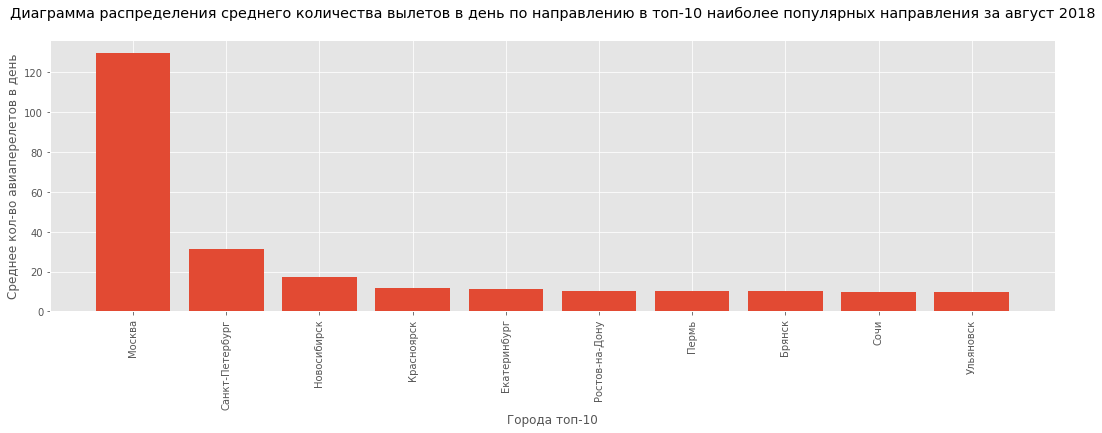

In [16]:
f, ax = plt.subplots(figsize=(18,5))
plot=plt.bar(top_10_city['city'], top_10_city['average_flights'])
x = plt.xticks(rotation='vertical')
plt.title('Диаграмма распределения среднего количества вылетов в день по направлению в топ-10 наиболее популярных направления за август 2018' + "\n")
plt.xlabel('Города топ-10')
plt.ylabel('Среднее кол-во авиаперелетов в день');

    Из графика по топ-10 городам мы наблюдаем, что наиболее популярные направления: Москва, Санкт-Петербург и Новосибирск, по остальным городам значения блазированы и держатся на отметке ниже среднего по всей выборке. В топ 10 направлений по количеству рейсов попали некоторые города-миллионики. Например, на 3-м месте: Новосибирск (примерно 1.6 млн. чел. население)., 4-е место: Красноярск (примерно 1 млн чел. население), 5-е место (примерно столько же рейсов, сколько на Красноярск): Екатеринубрг (примерно 1.5 млн. чел население), 6-е место: Ростов-на-Дону (примерно 1.3 млн. чел. населения), 7-е место: Пермь (примерно 1 млн. чел населения). В города миллионики, соответственно, летают чаще, принимая во внимание также тот факт, что эти города являются не только административными центрами субъектов, но и во многом крупнейшими городскими агломерациями для сотен населенных пунктов и других малых городов, рейсы на которые либо крайне редкие, либо чрезвычайно дорогие (если вообще есть). Например, по направлению в Екатеринбург, например, из Москвы, часто приобретают билеты жители сразу трех субъектов: Тюменской области, Свердловской области и ХМАО-Югра - Екатеринбург является железнодорожной столицей для этих регионов (в ХМАО и Тюменской области железных дорог дальнего следования просто нет - они начинаются с Екатеринбурга). Это обуславливает спрос по конкретным напрвлениям пассажиров. Брянск, Сочи и Ульяновск - не являются кородами миллиниками. Популярность направления рейсов на Сочи в августе можно объяснить продолжающимся курортным сезоном (бархатный сезон - август) в 2018 году. Брянск - административный центр Брянской области - Центральная Россия - в относительной близости от Москвы. Цены на билеты до Брянска отличаются своей дешевизной и относительной близости цены за жд билеты - в районе 1200 рублей в среднем. Примечательно также, что г. Брянск находится в непосредственной близости от границы с Украиной и Белоруссией. В условиях ограничения авиасообщений с Украиной, резиденты Украины могли приобретать билеты по этому направлению вместе с другими пассажирами, чтобы потом автотранспортом пересечь границу России и вернуться, например, домой. Тоже самое для резидентов Белоруссии. Важно, что на вторую декаду июля 2018 года приходится окончание Чемпионата Мира по футболу, состоявшегося в России. Следовательно, болельщики из вышеуказанных стран могли в августе возвращаться домой по этим направлениям, принимая вов нимание, например, что рейсов на Минск мало и они могли быть раскуплены. Ульновск - также находится в относительной близосте к Москве и расположен между двумя крупными городами - Казань (мегаполис) и Самарой - и отличается своей дешевизной на рейсы (в сравни с направлением, например, Казань). Жители сразу трех субъектов РФ могут потенциально приобрести билет по этому направлению.  

    Построим график: модель самолетов и количество рейсов

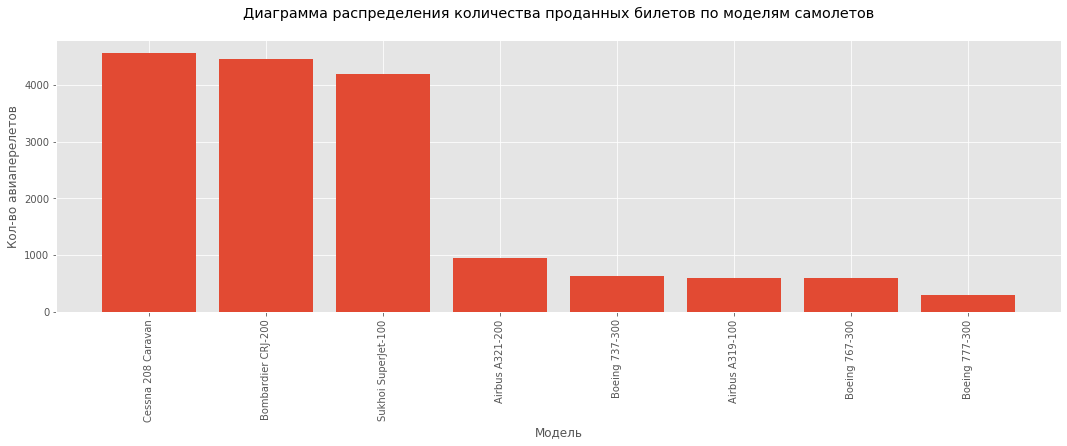

In [17]:
f, ax = plt.subplots(figsize=(18,5))
plot=plt.bar(models['model'], models['flights_amount'])
x = plt.xticks(rotation='vertical')
plt.title('Диаграмма распределения количества проданных билетов по моделям самолетов' + "\n")
plt.xlabel('Модель')
plt.ylabel('Кол-во авиаперелетов');

    Итак, исходя из графика, мы можем сделать вывод, что самыми продаваемыми билетами по всем известным нам направлениями являются рейсы трех моделей самолетов: Cessna 208 Caravan, Bombardier CRJ-200, Sukhoi SuperJet-100. Рейсы на модели других самолетов (в частности, более крупных, таких как Boeing и Airbus) - менее продаваемые за весь период

    Гипотезы специфики кол-ва рейсов по моделям самолетов. Весьма контринтуитивно, что на первом месте по спросу на авиаперелеты выступает модель самолета Сессна, которая, вообще говоря, используется на авиалиниях малой протяженности. Cessna 208 - это американский легкий одномоторный турбовинтовый самолет, вмещающий всего 13 пассажиров. На этой модели летают например, жители Аляски. Такие самолеты могут быть использованы членами правительства, иностранными делигациями, сборными спортивных команд для транспортировки (не забываем, что август 2018 года - период завершения мероприятий в рамках чемпионата мира по футболу, и тысячи футболистов, волонтеров, сотрудников обслуживающих компаний и пр. могли транспортировать на подобных самолетах в города и из городов - принимающих ЧМ 2018. Также такой самолет используют для спортивных, туристических полетов в горы (возможно, этим могли воспользоваться иностранные туристы, приехавшие в Россию на ЧМ). Bombardier CRJ-200 - канадский бизнес-джет - используются крупными предпринимателями, членами правительств, дип-миссий, представителями иностранных делигаций, который летают часто. Они вмещают в себя небольшое количество пассажиров, летают в сложных метерологических условиях и на дальние дистанции, из-за сниженного пассажиропотока - летают, соотвественно часто. Sukhoi Superjet 100 - российский пассажирский самолет, предназначенный для перевозки 98 пассажиров - довольно популярный в России - на нем как раз летают пассажиры в небольшие города, которые попали в статистику топ-10 по направлениям спроса авиаперелетов.

### Общий вывод

    Аналитические выводы
    В результате предварительного среза данных SQL запросов мы молучили два датасета: "Количество ависпарелетов в зависимости от модели самолета за Август 2018 года" и "Среднее количество рейсов за Август 2018 года в зависимости от города направления". В результате разведовательного анализа мы пришли к следующим выводам. 1. Неожиданно, самыми востребованными моделями самолетов оказались Cessna 208 Caravan и  Bombardier CRJ-200. Эти модели самолетов, как правило, не используют для пассажирского гражданского авиаперелета. Сессна - до 13 пассажиров - часто используется на коротких дистанциях в рамках туристических перелетов над сложными рельефными земными поверхностями, такими как, например, горы. Бомбардир, с другой стороны - используется для частных перелетов бизнес-классом. Мы предположили, что по окончанию ЧМ по футболу, состоявшегося в России в 2018 году, данные модели могли быть использованы для транспортировки многочисленных сотрудников, волонтеров, сборных команд, представителей иностранных делигаций, политиков, бизнесменов. Модель "Сухой" также оказалась весьма популярна - такие модели используют для перелетов по не густонаселенным пунктам или по направлениям с низким пассажиропотокам - например, в такие города как Ульяновск, Брянск, Пермь, Сочи. 2. Что же касается городов, то москваи Санкт-Петербург - абсолютные лидеры направлений - что объяснению не подлежит - Москва - международный хаб, через который пролегают авиасообщения всей страны, Санкт-Петербург - второй по величне город РФ. Между тем, в топ-10 попали 3 населенных пункта, которые не являются городами миллиониками, такие как: Брянск, Сочи, Ульяновск. Спрос по направлению Краснодарского края в августе весьма объясним продолжающимся курортным сезоном, в то же время, этот город не в абсолютных лидерах в августе 2018-го ввиду того, что в июне -июле в этом городе проходили футбольные матчи - в частности, знаменитый матч за выход в полуфинал между Россией и Хорватией, на которой теоретически могли прилететь большое количество болельщиков, включая тех болельщиков, которые успели купить билеты в Сочи, но команда, за которую они болели, неожиданным образом проиграла России. То есть по этому направлению в июне-июле успели отлетать. Брянск - близость к границе с Украиной - граждане этой страны могли покупать билеты по этому направлению (ввиду ограничения авиасообщений с Украиной) для того, чтобы из Брянска пересечь границу с Россией автотранспортом. Ульяновск - тоже популярное направление, обусловлено близостью двух крупных городов (Казанью и Самарой) - т.е. жители как минимум трех субъектов могли пользоваться этим направлением для того, чтобы добраться домой, принимая во внимание, что после ЧМ билеты в крупные города отличались дороговизной и могли быстро раскупаться. Спрос по направлением городов-миллиоников, так как, например, Екатеринбург, обуславливается тем, что эти города являются, зачастую, межрегиональными ЖД узлами для жителей близлежайших субъектов, в которых нет железных дорог. В случае с Екатеринбургом - спрос на это направление может быть обусловлен желанием добраться домой жителей Тюменской области и ХМАО, в которых нет железных дорог дальнего следования. Таким образом, они долетают до Екатеринбурга и пересаживаются на поезд. 
    Технические замечания
    В рамках анализа требутся выгрузить из SQL колонки с информацией о городе отправления - анализ этой информации мог бы расширить представление о спросе и объяснить причины популярности направлений.
    В рамках анализа было бы неплохо провести статистический тест, например, t-стьюдента, для того, чтобы сравнить средние значения перелетов по направлениям городов, в которых проходили и не проходили крупные фестивали (чтобы оценить влияние этого фактора на спрос).
    

